# 10. Frame-Selection based Gradients

In [1]:
from src import *

## Table of Contents
- [Frame selected emotion gradients](#comparison)

In [ ]:
mri_path400 = "./data/fmri414_compiled/"

<a class="anchor" id="comparison"></a>
### Frame selected emotion gradients

Selecting snippets for timecourses according to emotion strength 

In [12]:
select = ['Anger','Guilt','WarmHeartedness', \
             'Disgust','Happiness','Fear','Regard','Anxiety', \
             'Satisfaction','Pride','Surprise','Love','Sad']

tmpdf = pd.read_csv('./data/emotion_compileBIDS.csv')

Look at distribution of emotion timecourses values across all movies

(-2.0, 4.0)

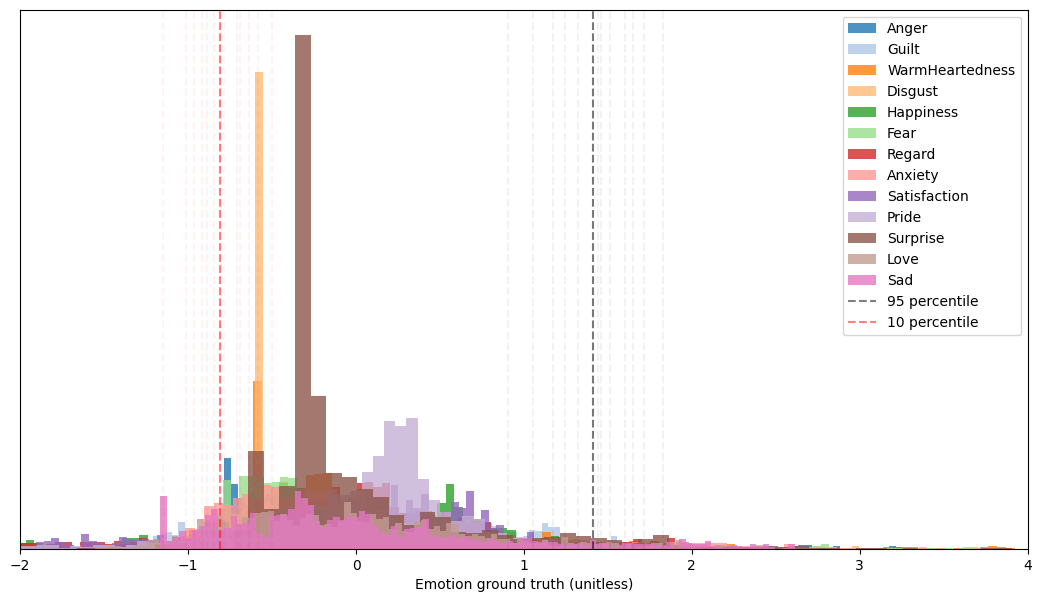

In [106]:
from matplotlib.colors import ListedColormap
pal     = sns.color_palette('tab20', len(select))
my_cmap = ListedColormap(pal)

plt.figure(figsize=(13,7))

ex  = []
exi = []
for idx,s in enumerate(select):
    distrib    = np.array(tmpdf[tmpdf.item == s]['score'])
    if len(distrib) == 0: continue
    percentile = np.argsort(distrib)[int(0.95 * distrib.shape[0])]
    invpercentile = np.argsort(distrib)[int(0.1 * distrib.shape[0])]
    val  = distrib[percentile]
    ival = distrib[invpercentile]

    ex.append(val)
    exi.append(ival)
    plt.hist(distrib, bins=100, alpha=0.8, label=s, color=my_cmap.colors[idx])
    plt.xlabel('Emotion ground truth (unitless)')
    plt.yticks([])
    plt.axvline(x = val,color='k', linestyle='--', alpha=0.05)
    plt.axvline(x = ival,color='r', linestyle='--', alpha=0.05)
    
plt.axvline(x = np.mean(ex),color='k', linestyle='--', alpha=0.5, label='95 percentile')
plt.axvline(x = np.mean(exi),color='r', linestyle='--', alpha=0.5, label='10 percentile')
plt.legend()
plt.xlim(-2,4)

In [97]:
# define cutoff for an emotion
rb = np.mean(ex)
lb = np.mean(exi)
print('Bound for positively intense emotion {}'.format(rb))
print('Bound for negatively intense emotion {}'.format(lb))

Bound for positively intense emotion 1.4091613170599282
Bound for negatively intense emotion -0.8072977844829355


Select frames (timecourses of fmri) according to the previously defined cutoff

In [99]:
selected_series = {m.split('_')[0]:{} for m in os.listdir(mri_path400)}
for movie_name400 in tqdm(os.listdir(mri_path400)):
    if "Rest" in movie_name400: continue        
    mri_df400mov  = pd.read_csv(mri_path400 + movie_name400)
    mname         = movie_name400.split('_')[0]
    
    film_duration = FILM2DURATION[mname] # in seconds
    duration_film = int(film_duration/ TR) # in number of TRs
    front_pad     = int(WASH + ONSET) + 1

    # Simply replace 400 by 414 to look at spatial relation with subcortical regions included
    movies = [m for m in mri_df400mov.filename.unique() if "414" in m] 
    movie_series = []
    for m in movies:
        tmp1, _  = df_to_timeseries(mri_df400mov, m)
        tmp1     = tmp1[front_pad :  front_pad + duration_film]
        movie_series.append(tmp1)
    movie_series = np.asarray(movie_series)

    absemo_df = pd.read_csv('./data/emotion_compileBIDS.csv')
    absemo_df = absemo_df[absemo_df['filename']=='W_{}13.csv'.format(mname)]

    # select from emotion timeseries frames with strong emotions
    for emo in absemo_df.item.unique():
        if emo not in select: continue
        tmp          = np.array(absemo_df[absemo_df.item == emo]['score'])
        tmp          = tmp[:movie_series.shape[1]]
        frame_select = np.where(tmp   > rb)[0]
        # append volume fmri corresponding to timestamp of intense positive emotion
        selected_series[mname][emo] = np.concatenate(movie_series[:,frame_select])

        
rest_series   = []
mri_df400rest = pd.read_csv(mri_path400 + "Rest_compiled414.csv")
rests         = [m for m in mri_df400rest.filename.unique() if "414" in m]
for r in rests:
    tmp2, _   = df_to_timeseries(mri_df400rest, r)
    rest_series.append(tmp2)
rests_series  = np.concatenate(rest_series)

  0%|          | 0/15 [00:00<?, ?it/s]

Group the emotion series together

In [101]:
selected_series['Rest'] = np.concatenate(rest_series)

# separating the extracted gradients
filmrest  = select + ['Rest']

select_series2 = {s:[] for s in filmrest}
for mov in selected_series:
    if mov == 'Rest':
        select_series2['Rest'].append(selected_series[mov])    
    else:
        for emo in selected_series[mov]:
            select_series2[emo].append(selected_series[mov][emo])

Compute Gradients for each emotion selected frames

In [102]:
# Params
embedding  = "dm" # diffusion map
aff_kernel = "pearson" #affinity matrix kernel
align_meth = "procrustes"
n_iter     = 10 # procrustes align number of iteration
nb_comp    = 3
rs         = 99

# Storing
gradients_select = {s: {} for s in selected_series}
gradients_emo    = []

# Computing gradients 1
fc_rests  = FC(rests_series)
g_rests   = GradientMaps(n_components=nb_comp, approach=embedding, 
                        kernel=aff_kernel, random_state=rs)
g_rests.fit(fc_rests)

gradients_select['Rest'] = {'Rest': g_rests.gradients_}

for label in selected_series:
    for emo in selected_series[label]:
        try:
            fc_dominant = FC(selected_series[label][emo])
            g           = GradientMaps(n_components=nb_comp, approach=embedding, kernel=aff_kernel, 
                              alignment=align_meth,random_state=rs)
            g.fit(fc_dominant, reference=g_rests.gradients_)
            gradients_select[label][emo] = g.aligned_
        except:
            continue

# Computing gradients 2
tmp = []
for f in filmrest:
    cur_series = np.concatenate(select_series2[f])
    g          = GradientMaps(n_components=nb_comp, approach=embedding, 
                        kernel=aff_kernel, random_state=rs)   
    if len(cur_series) == 0:
        tmp.append([])
        gradients_emo.append(gradients_emo[0])
        print(f)
        continue
    g.fit(FC(cur_series))
    tmp.append(FC(cur_series))
    gradients_emo.append(g.gradients_)

In [103]:
# alignement across all gradients
aligned,_,s = procrustes_align(np.asarray(gradients_emo))

Visualization of computed "emotion" gradients

  0%|          | 0/14 [00:00<?, ?it/s]

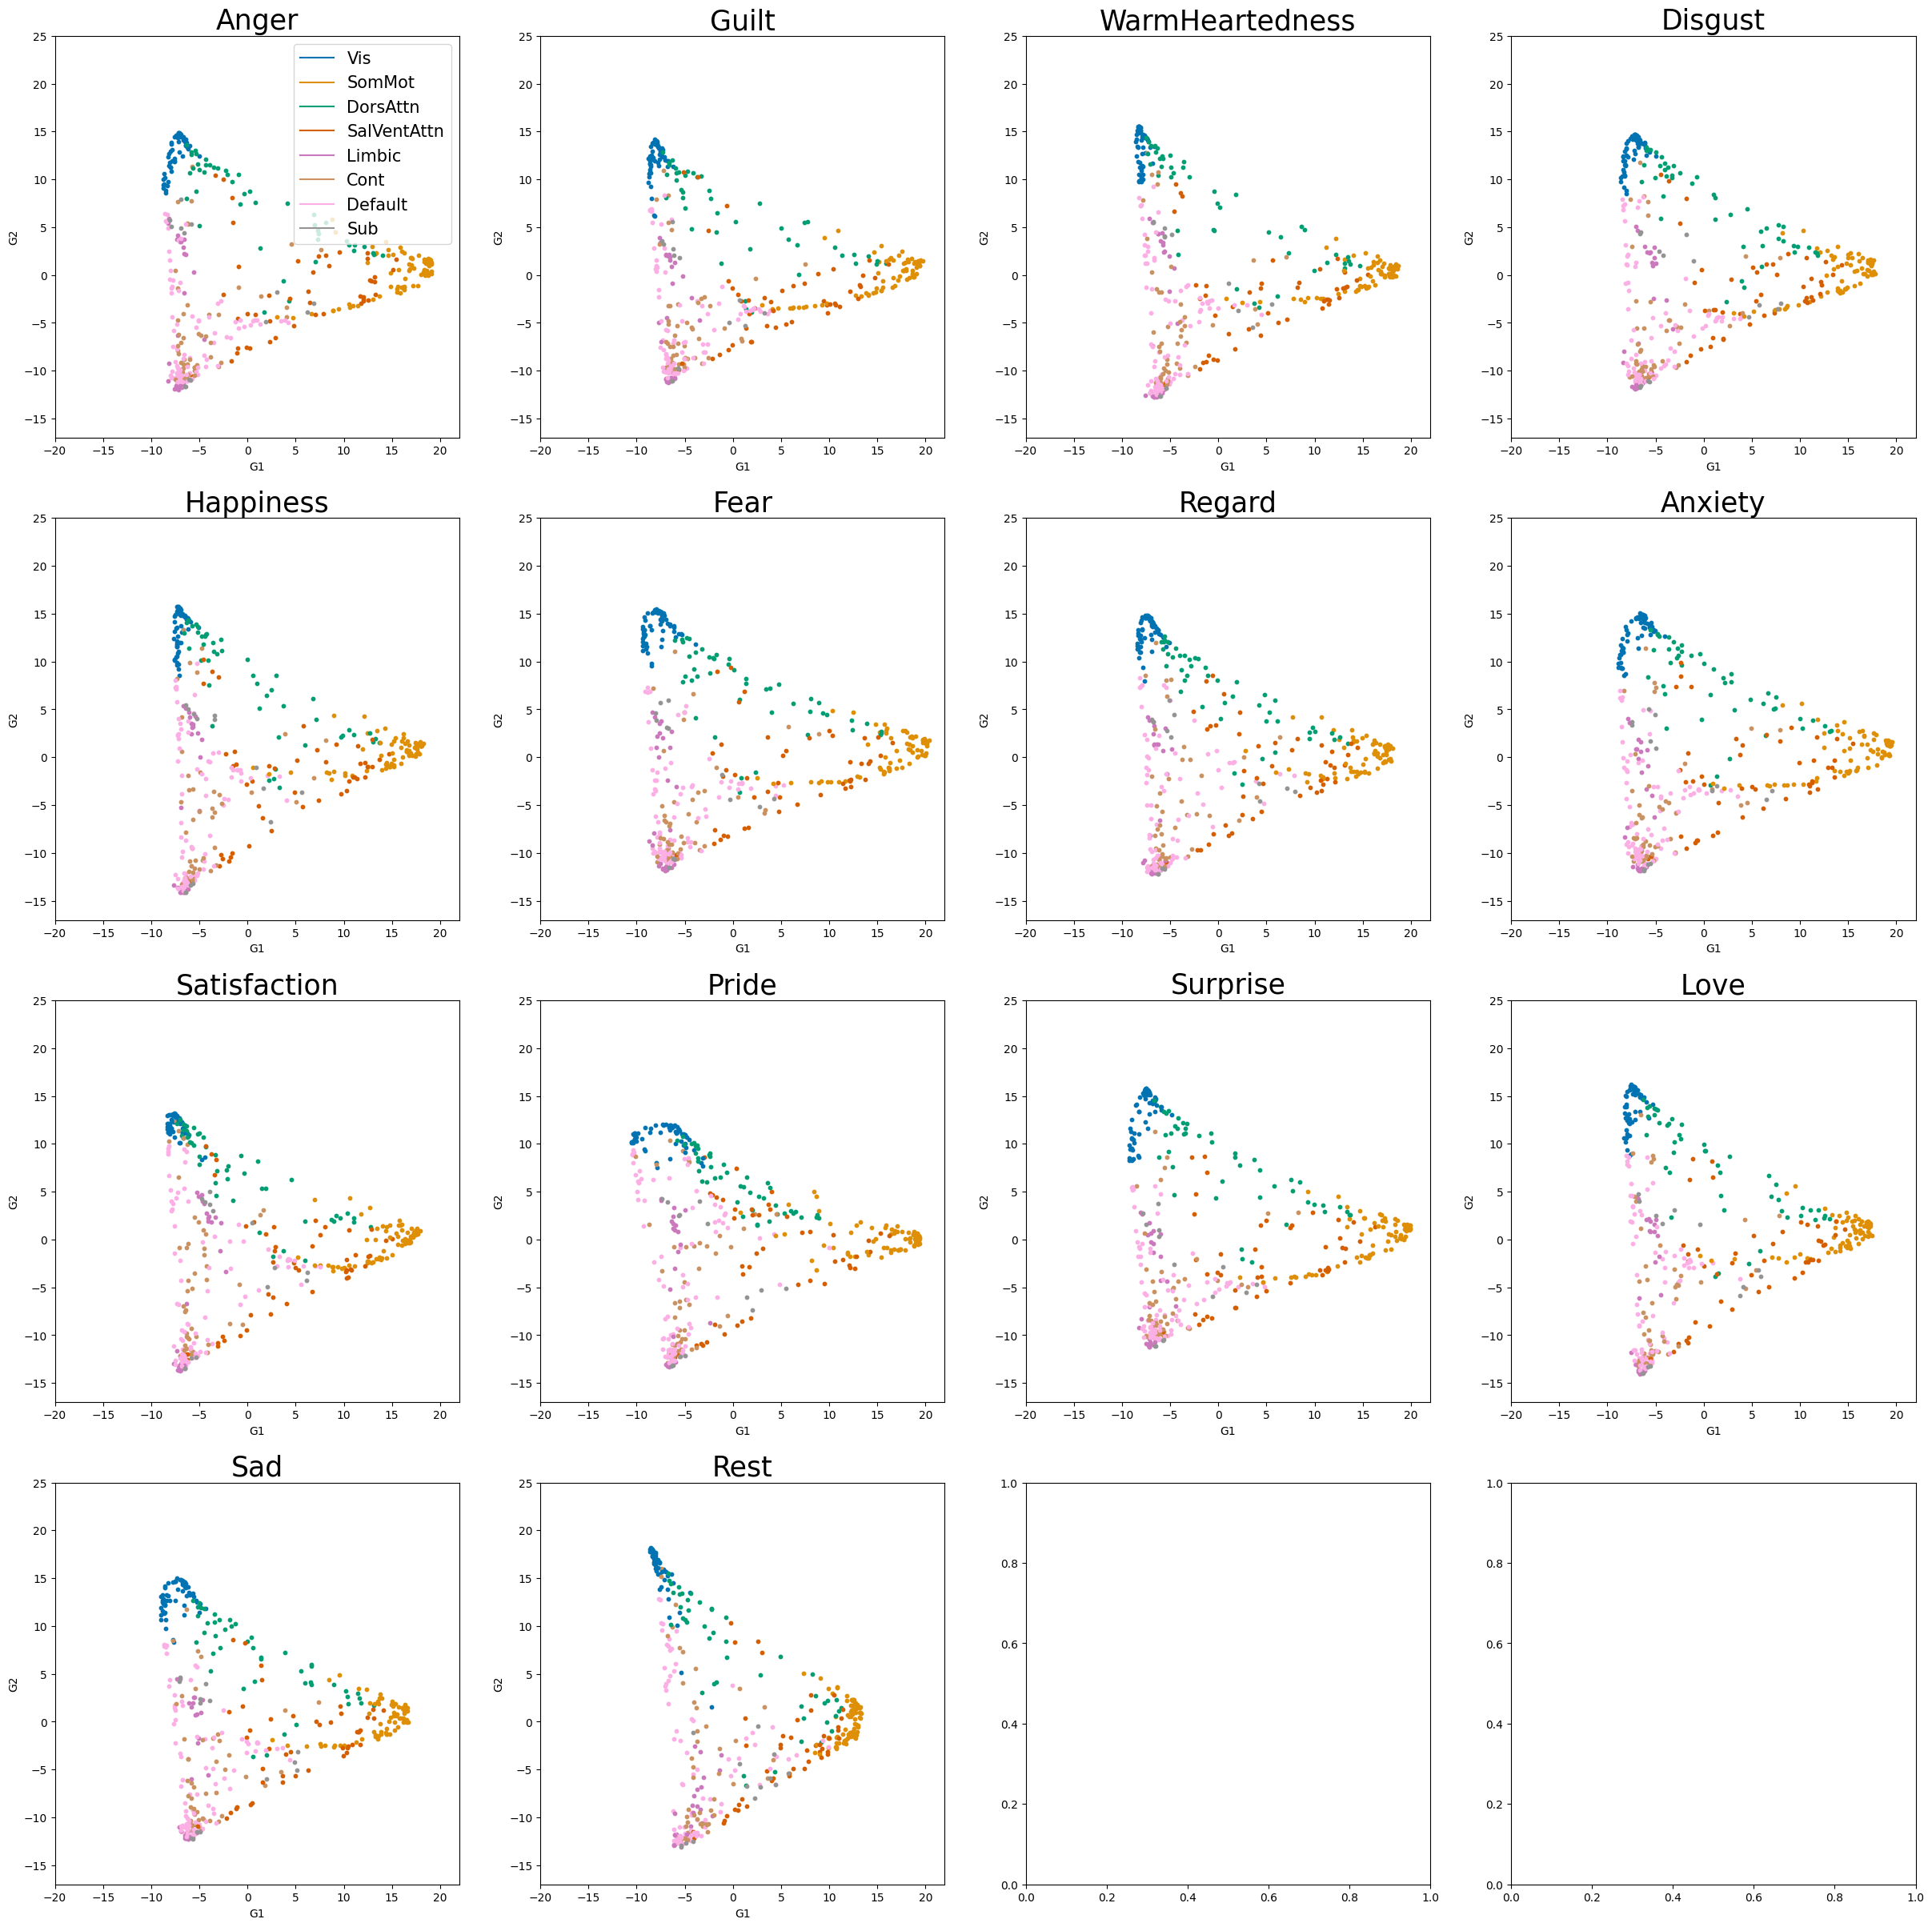

In [105]:
from matplotlib.colors import ListedColormap
pal     = sns.color_palette('colorblind', 8)
my_cmap = ListedColormap(pal)
partial_region = load('./resources/region414yeo7.pkl')
colors  = {N: my_cmap.colors[idx] for idx, N in enumerate(list(index2region.keys()))}

fig, axes = plt.subplots(4,4, figsize=(30,30))
for k in tqdm(range(len(filmrest))):
    row,col = k//4, k%4
    samples_grad = aligned[k]
    for i in range(len(samples_grad)):
        c   = partial_region[i]
        axes[row,col].scatter([samples_grad[i,0]], [samples_grad[i,1]], s=10, facecolor=colors[c])

    axes[row,col].set_title("{}".format(filmrest[k]), size=25)

    C       = list(colors.values())
    labels  = list(colors.keys())
    dummies = [axes[row,col].plot([], [], ls='-', c=c)[0] for c in C]

    axes[row,col].set_xlim(-20,22)
    axes[row,col].set_ylim(-17,25)
    axes[row,col].set_xlabel('G1')
    axes[row,col].set_ylabel('G2')
    
axes[0,0].legend(dummies, labels, loc=1, prop={'size':15})
plt.show()

Plot the different gradients per emotion per movie

  0%|          | 0/14 [00:00<?, ?it/s]

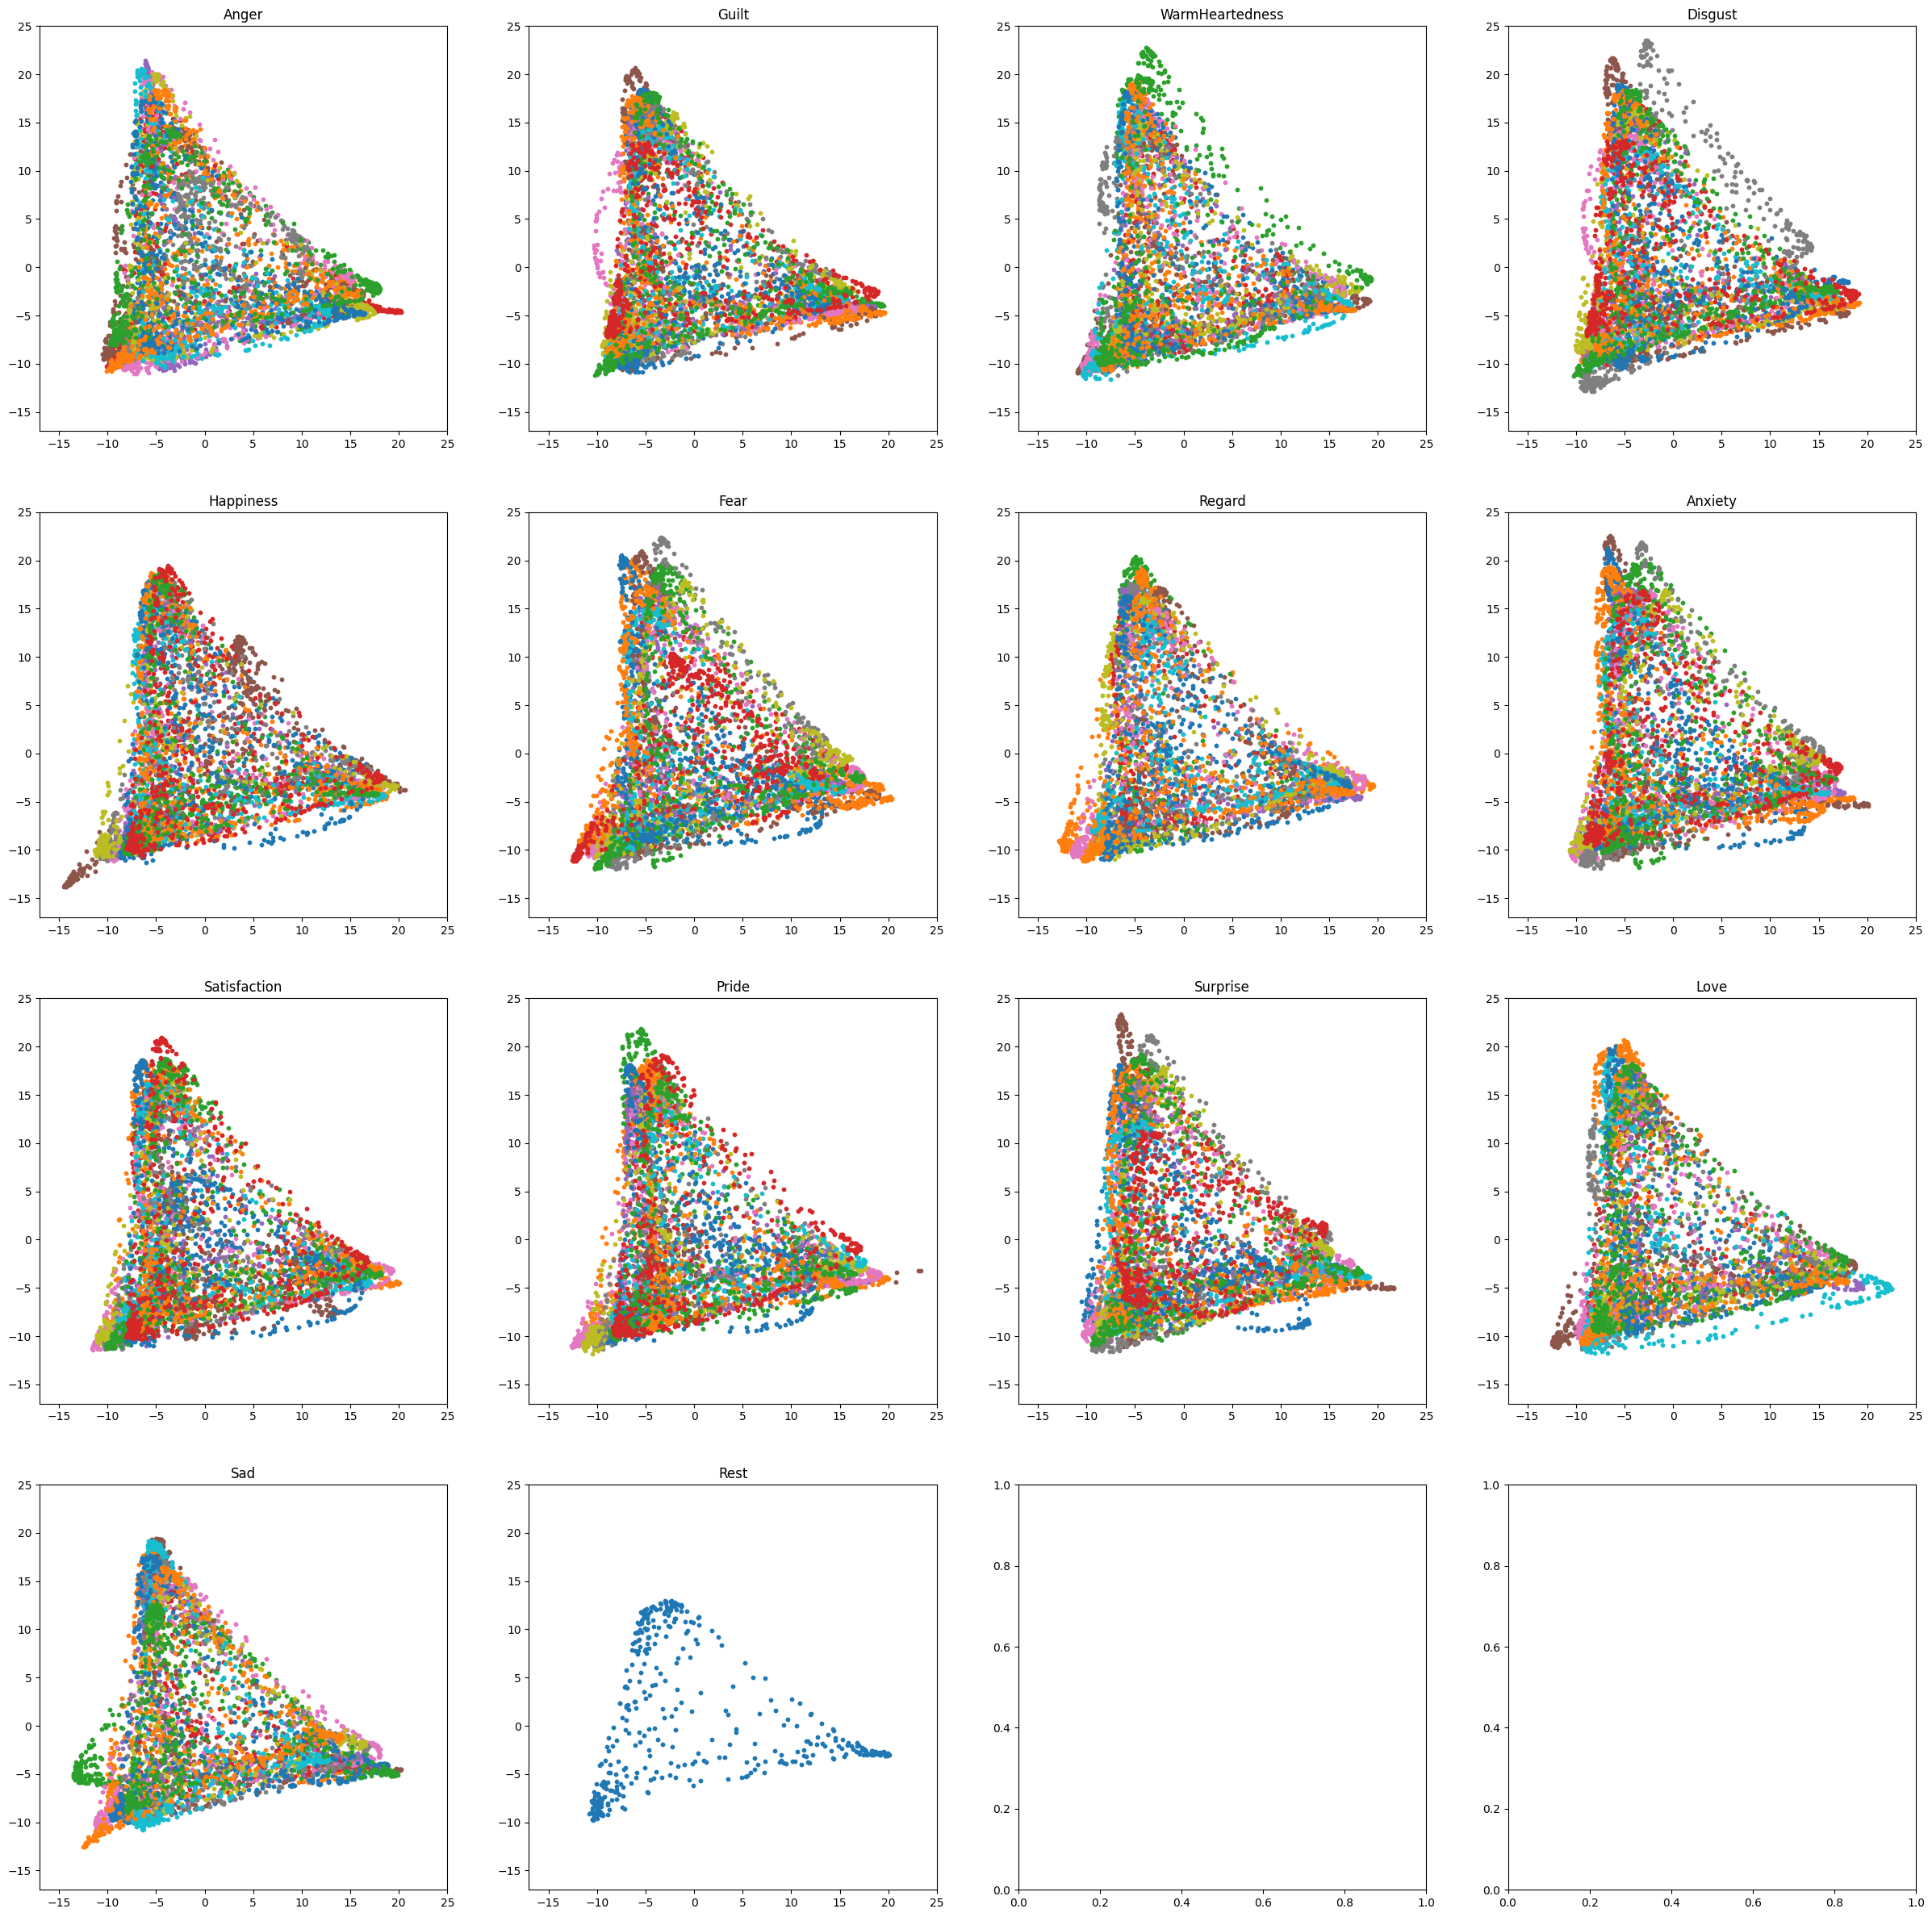

In [23]:
from matplotlib.colors import ListedColormap
pal     = sns.color_palette('colorblind', 8)
my_cmap = ListedColormap(pal)
partial_region = load('./resources/region400yeo7.pkl')
colors  = {N: my_cmap.colors[idx] for idx, N in enumerate(list(index2region.keys()))}

filmrest  = select + ['Rest']
fig, axes = plt.subplots(4,4, figsize=(30,30))
for k in tqdm(range(len(filmrest))):
    row,col = k//4, k%4
    for mov in gradients_select:
        if filmrest[k] not in gradients_select[mov]: continue

        samples_grad = gradients_select[mov][filmrest[k]]
        axes[row,col].scatter([samples_grad[:,0]], [samples_grad[:,1]], s=10)
#             for i in range(len(samples_grad)):
#                 c   = partial_region[i]
#                 axes[row,col].scatter([samples_grad[i,0]], [samples_grad[i,1]], s=10, facecolor=colors[c])

    axes[row,col].set_title("{}".format(filmrest[k]), size=12)

#     C       = list(colors.values())
#     labels  = list(colors.keys())
#     dummies = [axes[row,col].plot([], [], ls='-', c=c)[0] for c in C]
#     axes[row,col].legend(dummies, labels, loc=1, prop={'size':7})
    axes[row,col].set_xlim(-17,25)
    axes[row,col].set_ylim(-17,25)

plt.show()

Look at distribution per movie of each points

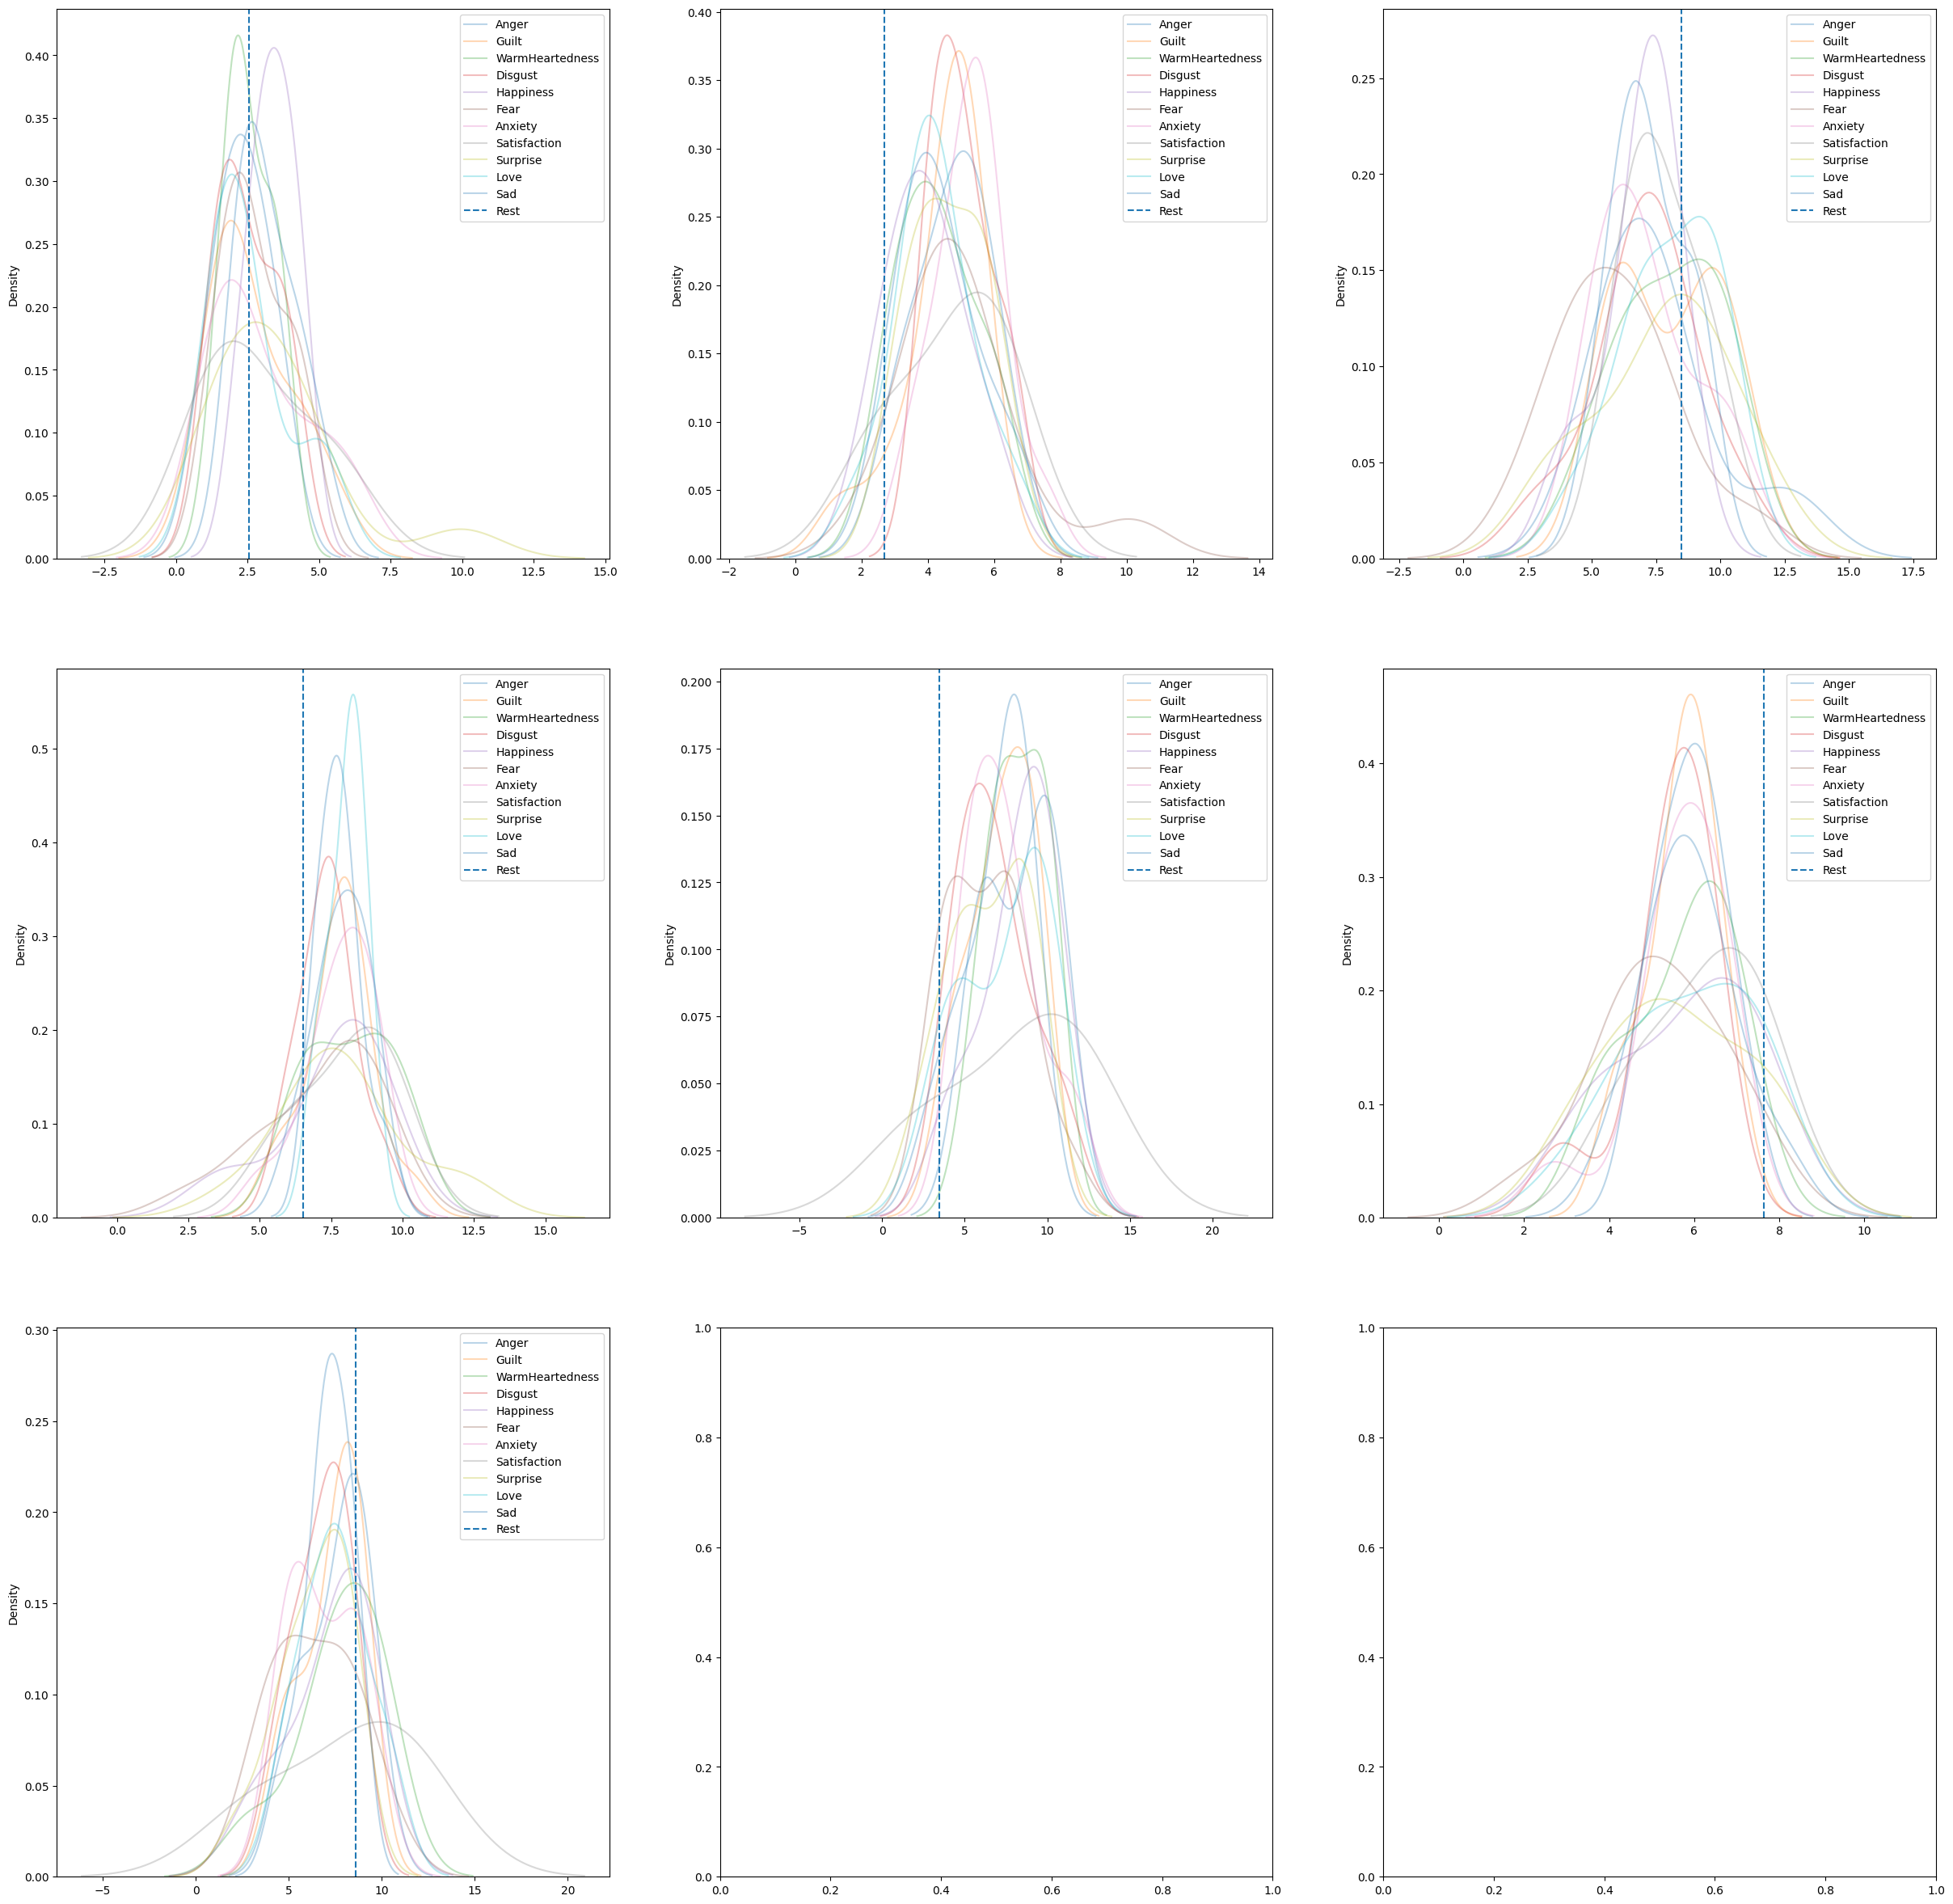

In [175]:
networks = list(index2region.keys())

# separating the extracted gradients
gradients2_select = {s:[] for s in filmrest}
for mov in gradients_select:
    for emo in gradients_select[mov]:
        if mov == 'Rest':
            gradients2_select['Rest'].append(gradients_select[mov][emo])
        else:
            gradients2_select[emo].append(gradients_select[mov][emo])


fig, axes = plt.subplots(3,3, figsize=(30,30))
for s in filmrest:
    tmp = np.asarray([np.asarray([network_volume(G, R) for idx, R in enumerate(networks)]) 
                for G in  gradients2_select[s]])
    if len(tmp) == 0: continue
#     print(tmp.shape[1])
    
    if s == 'Rest':
        for i in range(tmp.shape[1]):
            row,col = i//3, i%3            
            axes[row,col].axvline(x=tmp[0][i], label='Rest', linestyle='--')
    else:
        for i in range(tmp.shape[1]):
            row,col = i//3, i%3
            sns.kdeplot(tmp[:,i], label=s, alpha=0.3, ax = axes[row,col])
    #         axes[row,col].hist(tmp[:,i], label=s, alpha=0.3)
        
for i in range(7):
    row,col = i//3, i%3
    axes[row,col].legend()